# Bibliotecas usadas

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle as pkl

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Funções de utilidade

In [31]:
def show_hierarchical_results(precision, classes, title, subtitle, ylabel, adjust = 0, file_name = None):

  fig, ax = plt.subplots(figsize = (12, 6), dpi = 140)


  # Intervals of colors
  total_colours = ["#7dcafa", "#0a99f2"]

  # Building the colormaps
  cmap_total = mpl.colors.LinearSegmentedColormap.from_list("colour_map", total_colours, N = 256)
  norm_total = mpl.colors.Normalize(precision.min(), precision.max())


  # Plot bars
  ax.bar(classes, precision, width = 0.8, color = cmap_total(norm_total(precision)), zorder = 2)


  # Adding grids
  ax.grid(which = 'major', axis = 'x', color = '#c9c9c9', alpha = 0.4, zorder = 0)
  ax.grid(which = 'major', axis = 'y', color = '#c9c9c9', alpha = 0.4, zorder = 0)


  # Adding y title
  ax.set_ylabel(ylabel, fontsize = 12, labelpad = 10)


  # Adding title, subtitle and source
  ax.text(x = 0.12, y = 0.93, s = title, transform = fig.transFigure, ha = 'left', fontsize = 16, weight = 'bold', alpha = 0.8)
  ax.text(x = 0.12, y = 0.90, s = subtitle, transform = fig.transFigure, ha = 'left', fontsize = 14, alpha = 0.8)


  # Adding columns' numbers
  for i in range(len(classes)):
    height = round(precision[i], 4)
    month = classes[i]
    
    ax.annotate(f'{height}', xy = (month, height + adjust), ha = 'center', size = 10)


  # Adding line and rectangle
  ax.plot([0.12, 0.9], [0.98, 0.98], transform = fig.transFigure, clip_on = False, color = '#292826', linewidth = 0.6)
  ax.add_patch(plt.Rectangle((0.12, 0.98), 0.04, -0.02, facecolor = '#292826', transform = fig.transFigure, clip_on = False, linewidth = 0))


  # Adjust the margins around the plot area
  plt.subplots_adjust(left = None, bottom = 0.2, right = None, top = 0.85, wspace = None, hspace = None)


  # Set a white background
  fig.patch.set_facecolor('white')


  # Adjust ticks, ticks' number, remove frame and set a legend
  plt.xticks(rotation = 45)
  ax.set_frame_on(False);

  if file_name:
    plt.savefig(f"../data/files/results/visualizations/{file_name}.png")

In [64]:
def ensemble_mlp_scores(scores, classes):
  df_scores = pd.DataFrame()

  for i in range(len(classes)):
    test_accuracy = scores.at[i, "Acurácia no Teste"].mean()
    test_balanced_accuracy = scores.at[i, "Acurácia Balanceada no Teste"].mean()
    precision = scores.at[i, "Precisão"].mean()
    recall = scores.at[i, "Recall"].mean()
    f1 = scores.at[i, "F1"].mean()

    test_accuracy_std = scores.at[i, "Acurácia no Teste"].std()
    test_balanced_accuracy_std = scores.at[i, "Acurácia Balanceada no Teste"].std()
    precision_std = scores.at[i, "Precisão"].std()
    recall_std = scores.at[i, "Recall"].std()
    f1_std = scores.at[i, "F1"].std()

    auxiliary = pd.DataFrame(index = [classes[i]], data = {"Acurácia no Teste": test_accuracy, "Acurácia no Teste Std": test_accuracy_std, "Acurácia Balanceada no Teste": test_balanced_accuracy, "Acurácia Balanceada no Teste Std": test_balanced_accuracy_std, "Precisão": precision, "Precisão Std": precision_std, "Recall": recall, "Recall Std": recall_std, "F1": f1, "F1 Std": f1_std})

    df_scores = pd.concat([df_scores, auxiliary], axis = 0)

  return df_scores[["Acurácia no Teste", "Acurácia Balanceada no Teste", "Precisão", "Recall", "F1"]], df_scores[["Acurácia no Teste Std", "Acurácia Balanceada no Teste Std", "Precisão Std", "Recall Std", "F1 Std"]]

In [55]:
def hierarchical_accuracy_scores(scores):
  df_scores = pd.DataFrame()

  for i in range(len(scores)):
    accuracy_binary = scores[i][0]["Acurácia no Teste Binário"]
    accuracy_multiclass = scores[i][0]["Acurácia no Teste Multiclasse"]
    balanced_accuracy_binary = scores[i][0]["Acurácia Balanceada no Teste Binário"]
    balanced_accuracy_multiclasse = scores[i][0]["Acurácia Balanceada no Teste Multiclasse"]

    auxiliary = pd.DataFrame(data = {"Acurácia_Binário": accuracy_binary, "Acurácia_Multiclasse": accuracy_multiclass, "Acurácia_Balanceada_Binário": balanced_accuracy_binary, "Acurácia_Balanceada_Multiclasse": balanced_accuracy_multiclasse}, index = [i])
    df_scores = pd.concat([df_scores, auxiliary], axis = 0)

  
  accuracy_mean = pd.DataFrame(index = ["Mean"], data = {"Acurácia_Binário": df_scores["Acurácia_Binário"].mean(), "Acurácia_Multiclasse": df_scores["Acurácia_Multiclasse"].mean(), "Acurácia_Balanceada_Binário": df_scores["Acurácia_Balanceada_Binário"].mean(), "Acurácia_Balanceada_Multiclasse": df_scores["Acurácia_Balanceada_Multiclasse"].mean()})
  accuracy_std = pd.DataFrame(index = ["Std"], data = {"Acurácia_Binário": df_scores["Acurácia_Binário"].std(), "Acurácia_Multiclasse": df_scores["Acurácia_Multiclasse"].std(), "Acurácia_Balanceada_Binário": df_scores["Acurácia_Balanceada_Binário"].std(), "Acurácia_Balanceada_Multiclasse": df_scores["Acurácia_Balanceada_Multiclasse"].std()})

  df_scores = pd.concat([df_scores, accuracy_mean, accuracy_std], axis = 0)

  return df_scores

In [60]:
def hierarchical_multiclass_scores(scores, classes):
  df_scores = pd.DataFrame(index = classes)

  for i in range(len(scores)):
    precision = scores[i][0]["Precisão Multiclasse"]
    f1 = scores[i][0]["F1 Multiclasse"]
    recall = scores[i][0]["Recall Multiclasse"]

    auxiliary = pd.DataFrame(index = classes, data = {f"Precisão_{i}": precision, f"Recall_{i}": recall, f"F1_{i}": f1})
    df_scores = pd.concat([df_scores, auxiliary], axis = 1)

  
  df_scores["Precision_Mean"] = df_scores[[f"Precisão_{i}" for i in range(len(scores))]].mean(axis = 1)
  df_scores["Recall_Mean"] = df_scores[[f"Recall_{i}" for i in range(len(scores))]].mean(axis = 1)
  df_scores["F1_Mean"] = df_scores[[f"F1_{i}" for i in range(len(scores))]].mean(axis = 1)

  df_scores["Precision_Std"] = df_scores[[f"Precisão_{i}" for i in range(len(scores))]].std(axis = 1)
  df_scores["Recall_Std"] = df_scores[[f"Recall_{i}" for i in range(len(scores))]].std(axis = 1)
  df_scores["F1_Std"] = df_scores[[f"F1_{i}" for i in range(len(scores))]].std(axis = 1)

  return df_scores[["Precision_Mean", "Recall_Mean", "F1_Mean"]], df_scores[["Precision_Std", "Recall_Std", "F1_Std"]]
  

In [61]:
def hierarchical_binary_scores(scores, classes):

  df_scores = pd.DataFrame(index = classes)
  for i in range(len(scores)):
    precision = scores[i][0]["Precisão Binário"]
    f1 = scores[i][0]["F1 Binário"]
    recall = scores[i][0]["Recall Binário"]

    auxiliary = pd.DataFrame(index = classes, data = {f"Precisão_{i}": precision, f"Recall_{i}": recall, f"F1_{i}": f1})
    df_scores = pd.concat([df_scores, auxiliary], axis = 1)

  
  df_scores["Precision_Mean"] = df_scores[[f"Precisão_{i}" for i in range(len(scores))]].mean(axis = 1)
  df_scores["Recall_Mean"] = df_scores[[f"Recall_{i}" for i in range(len(scores))]].mean(axis = 1)
  df_scores["F1_Mean"] = df_scores[[f"F1_{i}" for i in range(len(scores))]].mean(axis = 1)

  df_scores["Precision_Std"] = df_scores[[f"Precisão_{i}" for i in range(len(scores))]].std(axis = 1)
  df_scores["Recall_Std"] = df_scores[[f"Recall_{i}" for i in range(len(scores))]].std(axis = 1)
  df_scores["F1_Std"] = df_scores[[f"F1_{i}" for i in range(len(scores))]].std(axis = 1)

  return df_scores[["Precision_Mean", "Recall_Mean", "F1_Mean"]], df_scores[["Precision_Std", "Recall_Std", "F1_Std"]]
  

# Carrega-se os dados pré-processados

In [8]:
df = pkl.load(open("../data/files/Normalized_Data.pkl", "rb"))

In [9]:
X = df.drop(columns = ["attack_cat", "Label"])
y = df[["attack_cat", "Label"]]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y[["Label", "attack_cat"]], test_size = 0.2, stratify = y, random_state = 42)

del df

# Importação dos modelos treinados

In [11]:
ada_boost_binary = pkl.load(open("../data/utilities/models/ada_boost_binary.pkl", "rb"))
random_forest_binary = pkl.load(open("../data/utilities/models/random_forest_binary.pkl", "rb"))
bagging_binary = pkl.load(open("../data/utilities/models/bagging_binary.pkl", "rb"))
mlp_binary = pkl.load(open("../data/utilities/models/mlp_binary.pkl", "rb"))
xgboost_binary = pkl.load(open("../data/utilities/models/xgboost_binary.pkl", "rb"))

ada_boost_multiclass = pkl.load(open("../data/utilities/models/ada_boost_multiclass.pkl", "rb"))
random_forest_multiclass = pkl.load(open("../data/utilities/models/random_forest_multiclass.pkl", "rb"))
bagging_multiclass = pkl.load(open("../data/utilities/models/bagging_multiclass.pkl", "rb"))
mlp_multiclass = pkl.load(open("../data/utilities/models/mlp_multiclass.pkl", "rb"))
xgboost_multiclass = pkl.load(open("../data/utilities/models/xgboost_multiclass.pkl", "rb"))

local_classifier_per_node = pkl.load(open("../data/utilities/models/local_classifier_per_node.pkl", "rb"))
local_classifier_per_parent_node = pkl.load(open("../data/utilities/models/local_classifier_per_parent_node.pkl", "rb"))
local_classifier_per_level = pkl.load(open("../data/utilities/models/local_classifier_per_level.pkl", "rb"))

# Importação de dados de resultado da validação cruzada

In [12]:
local_classifier_per_node_scores = pkl.load(open("../data/files/results/local_classifier_per_node_scores.pkl", "rb"))
local_classifier_per_parent_node_scores = pkl.load(open("../data/files/results/local_classifier_per_parent_node_scores.pkl", "rb"))
local_classifier_per_level_scores = pkl.load(open("../data/files/results/local_classifier_per_level_scores.pkl", "rb"))

ada_boost_scores_multiclass = pkl.load(open("../data/files/results/ada_boost_scores_multiclass.pkl", "rb"))
random_forest_scores_multiclass = pkl.load(open("../data/files/results/random_forest_scores_multiclass.pkl", "rb"))
bagging_scores_multiclass = pkl.load(open("../data/files/results/bagging_scores_multiclass.pkl", "rb"))
mlp_scores_multiclass = pkl.load(open("../data/files/results/mlp_scores_multiclass.pkl", "rb"))
xgboost_scores_multiclass = pkl.load(open("../data/files/results/xgboost_scores_multiclass.pkl", "rb"))

ada_boost_scores_binary = pkl.load(open("../data/files/results/ada_boost_scores_binary.pkl", "rb"))
random_forest_scores_binary = pkl.load(open("../data/files/results/random_forest_scores_binary.pkl", "rb"))
bagging_scores_binary = pkl.load(open("../data/files/results/bagging_scores_binary.pkl", "rb"))
mlp_scores_binary = pkl.load(open("../data/files/results/mlp_scores_binary.pkl", "rb"))
xgboost_scores_binary = pkl.load(open("../data/files/results/xgboost_scores_binary.pkl", "rb"))

# Carrega-se o codificador/decodificador dos tipos de ataques

In [13]:
attack_cat_encoder = pkl.load(open("../data/utilities/models/attack_cat_label_encoder.pkl", "rb"))

# Visualizações dos resultados

In [14]:
attack_cat = attack_cat_encoder.classes_[:-1]
attack_cat = np.append(attack_cat, "Normal")
attack_cat

array(['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Reconnaissance', 'Shellcode', 'Worms', 'Normal'], dtype=object)

In [15]:
label = np.array(["Normal", "Attack"])
label

array(['Normal', 'Attack'], dtype='<U6')

In [16]:
attacks_number = y["attack_cat"].value_counts().sort_index()
attacks_number

attack_cat
0       2677
1       2329
2      16353
3      44525
4      24246
5     215481
6      13987
7       1511
8        174
9    2218751
Name: count, dtype: int64

## Informações sobre a base UNSW-NB15

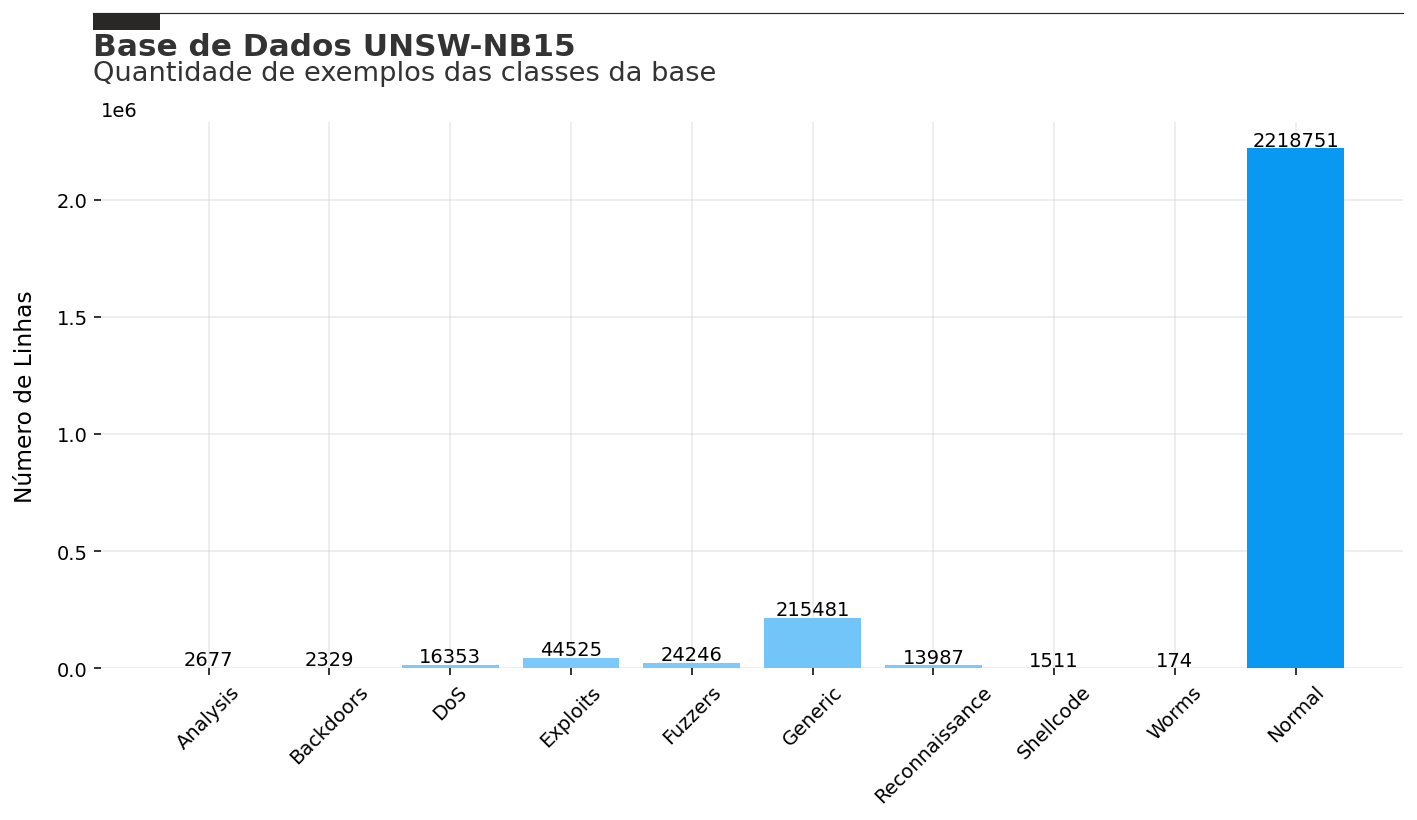

In [33]:
show_hierarchical_results(attacks_number, attack_cat, title = "Base de Dados UNSW-NB15", subtitle = "Quantidade de exemplos das classes da base", ylabel = "Número de Linhas", adjust = 10000, file_name = "unsw_nb15_classes.png")

## Resultados dos modelos ensemble e mlp

### Métricas dos modelos em classificação binária

In [65]:
ada_boost_binary_means = ensemble_mlp_scores(ada_boost_scores_binary, label)
random_forest_binary_means = ensemble_mlp_scores(random_forest_scores_binary, label)
bagging_binary_means = ensemble_mlp_scores(bagging_scores_binary, label)
mlp_binary_means = ensemble_mlp_scores(mlp_scores_binary, label)
xgboost_binary_means = ensemble_mlp_scores(xgboost_scores_binary, label)

In [69]:
ada_boost_binary_means[0]

,Acurácia no Teste,Acurácia Balanceada no Teste,Precisão,Recall,F1
Normal,0.99008,0.984432,0.996627,0.991997,0.994306
Attack,0.99008,0.984432,0.946629,0.976867,0.961496


In [70]:
ada_boost_binary_means[1]

,Acurácia no Teste Std,Acurácia Balanceada no Teste Std,Precisão Std,Recall Std,F1 Std
Normal,0.000468,0.001027,0.000414,0.000907,0.000275
Attack,0.000468,0.001027,0.005474,0.002891,0.001539


In [71]:
random_forest_binary_means[0]

,Acurácia no Teste,Acurácia Balanceada no Teste,Precisão,Recall,F1
Normal,0.992835,0.981564,0.995139,0.996663,0.995900
Attack,0.992835,0.981564,0.976767,0.966465,0.971588


In [72]:
random_forest_binary_means[1]

,Acurácia no Teste Std,Acurácia Balanceada no Teste Std,Precisão Std,Recall Std,F1 Std
Normal,0.00021,0.000718,0.000209,0.000068,0.000121
Attack,0.00021,0.000718,0.000350,0.001418,0.000798


In [324]:
bagging_binary_means[0]

,Acurácia no Teste,Acurácia Balanceada no Teste,Precisão,Recall,F1
Normal,0.986528,0.991463,0.999716,0.984851,0.992228
Attack,0.986528,0.991463,0.905347,0.998075,0.949452


In [73]:
bagging_binary_means[1]

,Acurácia no Teste Std,Acurácia Balanceada no Teste Std,Precisão Std,Recall Std,F1 Std
Normal,0.000228,0.000263,0.000066,0.000258,0.000138
Attack,0.000228,0.000263,0.001042,0.000443,0.000595


In [74]:
mlp_binary_means[0]

,Acurácia no Teste,Acurácia Balanceada no Teste,Precisão,Recall,F1
Normal,0.989932,0.981786,0.995765,0.992697,0.994227
Attack,0.989932,0.981786,0.950908,0.970876,0.960703


In [75]:
mlp_binary_means[1]

,Acurácia no Teste Std,Acurácia Balanceada no Teste Std,Precisão Std,Recall Std,F1 Std
Normal,0.000876,0.005266,0.001697,0.001580,0.000503
Attack,0.000876,0.005266,0.009373,0.011786,0.003441


In [76]:
xgboost_binary_means[0]

,Acurácia no Teste,Acurácia Balanceada no Teste,Precisão,Recall,F1
Normal,0.992021,0.982725,0.995682,0.995178,0.995430
Attack,0.992021,0.982725,0.966901,0.970272,0.968583


In [77]:
xgboost_binary_means[1]

,Acurácia no Teste Std,Acurácia Balanceada no Teste Std,Precisão Std,Recall Std,F1 Std
Normal,0.000179,0.000221,0.000072,0.000191,0.000106
Attack,0.000179,0.000221,0.001108,0.000439,0.000543


### Métricas dos modelos em classificação multiclasse

In [78]:
ada_boost_multiclass_means = ensemble_mlp_scores(ada_boost_scores_multiclass, attack_cat)
random_forest_multiclass_means = ensemble_mlp_scores(random_forest_scores_multiclass, attack_cat)
bagging_multiclass_means = ensemble_mlp_scores(bagging_scores_multiclass, attack_cat)
mlp_multiclass_means = ensemble_mlp_scores(mlp_scores_multiclass, attack_cat)
xgboost_multiclass_means = ensemble_mlp_scores(xgboost_scores_multiclass, attack_cat)

In [80]:
ada_boost_multiclass_means[0]

,Acurácia no Teste,Acurácia Balanceada no Teste,Precisão,Recall,F1
Analysis,0.963769,0.42039,0.049700,0.460048,0.089426
Backdoors,0.963769,0.42039,0.033755,0.036515,0.025713
DoS,0.963769,0.42039,0.247432,0.138318,0.135973
Exploits,0.963769,0.42039,0.643191,0.561701,0.585021
Fuzzers,0.963769,0.42039,0.357247,0.319173,0.321097
Generic,0.963769,0.42039,0.987042,0.974678,0.980808
Reconnaissance,0.963769,0.42039,0.560558,0.650585,0.599229
Shellcode,0.963769,0.42039,0.000000,0.000000,0.000000
Worms,0.963769,0.42039,0.069811,0.074762,0.062739
Normal,0.963769,0.42039,0.991638,0.988117,0.989862


In [81]:
ada_boost_multiclass_means[1]

,Acurácia no Teste Std,Acurácia Balanceada no Teste Std,Precisão Std,Recall Std,F1 Std
Analysis,0.00366,0.01605,0.007408,0.065894,0.011862
Backdoors,0.00366,0.01605,0.030579,0.056022,0.024922
DoS,0.00366,0.01605,0.025277,0.185867,0.107453
Exploits,0.00366,0.01605,0.044040,0.154408,0.083302
Fuzzers,0.00366,0.01605,0.051920,0.131923,0.070385
Generic,0.00366,0.01605,0.007388,0.001327,0.003360
Reconnaissance,0.00366,0.01605,0.027525,0.080660,0.031176
Shellcode,0.00366,0.01605,0.000000,0.000000,0.000000
Worms,0.00366,0.01605,0.076923,0.054022,0.045643
Normal,0.00366,0.01605,0.002895,0.005217,0.001479


In [82]:
random_forest_multiclass_means[0]

,Acurácia no Teste,Acurácia Balanceada no Teste,Precisão,Recall,F1
Analysis,0.983547,0.584948,0.871317,0.121515,0.212761
Backdoors,0.983547,0.584948,0.817051,0.097931,0.174462
DoS,0.983547,0.584948,0.309749,0.235063,0.267138
Exploits,0.983547,0.584948,0.631257,0.824145,0.714890
Fuzzers,0.983547,0.584948,0.779630,0.683635,0.728400
Generic,0.983547,0.584948,0.997990,0.987289,0.992611
Reconnaissance,0.983547,0.584948,0.925980,0.780141,0.846814
Shellcode,0.983547,0.584948,0.844426,0.901570,0.871401
Worms,0.983547,0.584948,0.644286,0.219683,0.323480
Normal,0.983547,0.584948,0.997471,0.998512,0.997991


In [83]:
random_forest_multiclass_means[1]

,Acurácia no Teste Std,Acurácia Balanceada no Teste Std,Precisão Std,Recall Std,F1 Std
Analysis,0.00019,0.006296,0.056395,0.018372,0.027934
Backdoors,0.00019,0.006296,0.094251,0.025596,0.042614
DoS,0.00019,0.006296,0.009501,0.014207,0.011467
Exploits,0.00019,0.006296,0.004040,0.008044,0.002619
Fuzzers,0.00019,0.006296,0.013173,0.004958,0.003216
Generic,0.00019,0.006296,0.000341,0.000785,0.000449
Reconnaissance,0.00019,0.006296,0.004943,0.003995,0.002341
Shellcode,0.00019,0.006296,0.032506,0.027736,0.015410
Worms,0.00019,0.006296,0.126006,0.052427,0.066074
Normal,0.00019,0.006296,0.000171,0.000151,0.000106


In [84]:
bagging_multiclass_means[0]

,Acurácia no Teste,Acurácia Balanceada no Teste,Precisão,Recall,F1
Analysis,0.873237,0.1,NaN,0.0,0.000000
Backdoors,0.873237,0.1,NaN,0.0,0.000000
DoS,0.873237,0.1,NaN,0.0,0.000000
Exploits,0.873237,0.1,NaN,0.0,0.000000
Fuzzers,0.873237,0.1,NaN,0.0,0.000000
Generic,0.873237,0.1,NaN,0.0,0.000000
Reconnaissance,0.873237,0.1,NaN,0.0,0.000000
Shellcode,0.873237,0.1,NaN,0.0,0.000000
Worms,0.873237,0.1,NaN,0.0,0.000000
Normal,0.873237,0.1,0.873237,1.0,0.932329


In [92]:
bagging_multiclass_means[1]

,Acurácia no Teste Std,Acurácia Balanceada no Teste Std,Precisão Std,Recall Std,F1 Std
Analysis,0.0006,0.0,NaN,0.0,0.000000
Backdoors,0.0006,0.0,NaN,0.0,0.000000
DoS,0.0006,0.0,NaN,0.0,0.000000
Exploits,0.0006,0.0,NaN,0.0,0.000000
Fuzzers,0.0006,0.0,NaN,0.0,0.000000
Generic,0.0006,0.0,NaN,0.0,0.000000
Reconnaissance,0.0006,0.0,NaN,0.0,0.000000
Shellcode,0.0006,0.0,NaN,0.0,0.000000
Worms,0.0006,0.0,NaN,0.0,0.000000
Normal,0.0006,0.0,0.0006,0.0,0.000342


In [86]:
mlp_multiclass_means[0]

,Acurácia no Teste,Acurácia Balanceada no Teste,Precisão,Recall,F1
Analysis,0.979068,0.510448,0.609618,0.023673,0.044621
Backdoors,0.979068,0.510448,0.644488,0.059450,0.106346
DoS,0.979068,0.510448,0.417983,0.330088,0.273759
Exploits,0.979068,0.510448,0.658738,0.766836,0.687759
Fuzzers,0.979068,0.510448,0.670194,0.437320,0.523099
Generic,0.979068,0.510448,0.993927,0.983560,0.988716
Reconnaissance,0.979068,0.510448,0.819709,0.754799,0.784980
Shellcode,0.979068,0.510448,0.515739,0.508747,0.504477
Worms,0.979068,0.510448,0.360000,0.242540,0.221685
Normal,0.979068,0.510448,0.994035,0.997467,0.995748


In [90]:
mlp_multiclass_means[1]

,Acurácia no Teste Std,Acurácia Balanceada no Teste Std,Precisão Std,Recall Std,F1 Std
Analysis,0.000585,0.040709,0.265125,0.020212,0.036654
Backdoors,0.000585,0.040709,0.158881,0.023299,0.038498
DoS,0.000585,0.040709,0.106859,0.318446,0.173810
Exploits,0.000585,0.040709,0.099236,0.177334,0.028693
Fuzzers,0.000585,0.040709,0.065906,0.066727,0.027387
Generic,0.000585,0.040709,0.000886,0.000863,0.000483
Reconnaissance,0.000585,0.040709,0.043247,0.027294,0.018071
Shellcode,0.000585,0.040709,0.069056,0.098002,0.050255
Worms,0.000585,0.040709,0.261367,0.271713,0.134337
Normal,0.000585,0.040709,0.000400,0.000479,0.000125


In [88]:
xgboost_multiclass_means[0]

,Acurácia no Teste,Acurácia Balanceada no Teste,Precisão,Recall,F1
Analysis,0.98352,0.610389,0.848095,0.084735,0.153981
Backdoors,0.98352,0.610389,0.893626,0.096329,0.173710
DoS,0.98352,0.610389,0.434234,0.300773,0.355235
Exploits,0.98352,0.610389,0.650545,0.864893,0.742513
Fuzzers,0.98352,0.610389,0.746045,0.604409,0.667615
Generic,0.98352,0.610389,0.997497,0.987327,0.992386
Reconnaissance,0.98352,0.610389,0.921843,0.787112,0.849157
Shellcode,0.98352,0.610389,0.878125,0.906155,0.891304
Worms,0.98352,0.610389,0.622240,0.474127,0.536058
Normal,0.98352,0.610389,0.996349,0.998032,0.997190


In [89]:
xgboost_multiclass_means[1]

,Acurácia no Teste Std,Acurácia Balanceada no Teste Std,Precisão Std,Recall Std,F1 Std
Analysis,0.000279,0.011347,0.052733,0.010251,0.017436
Backdoors,0.000279,0.011347,0.068484,0.017689,0.029928
DoS,0.000279,0.011347,0.014471,0.011609,0.009958
Exploits,0.000279,0.011347,0.009170,0.007539,0.006011
Fuzzers,0.000279,0.011347,0.018360,0.011898,0.007811
Generic,0.000279,0.011347,0.000371,0.000735,0.000483
Reconnaissance,0.000279,0.011347,0.005421,0.003874,0.003414
Shellcode,0.000279,0.011347,0.029204,0.034638,0.018721
Worms,0.000279,0.011347,0.110054,0.100276,0.102827
Normal,0.000279,0.011347,0.000129,0.000085,0.000080


## Resultados dos modelos hierárquicos

In [93]:
local_classifier_per_node_means_general = hierarchical_accuracy_scores(local_classifier_per_node_scores[0])
local_classifier_per_parent_node_means_general = hierarchical_accuracy_scores(local_classifier_per_parent_node_scores[0])
local_classifier_per_level_means_general = hierarchical_accuracy_scores(local_classifier_per_level_scores[0])

local_classifier_per_level_means_multiclass = hierarchical_multiclass_scores(local_classifier_per_level_scores[0], attack_cat)
local_classifier_per_parent_node_means_multiclass = hierarchical_multiclass_scores(local_classifier_per_parent_node_scores[0], attack_cat)
local_classifier_per_node_means_multiclass = hierarchical_multiclass_scores(local_classifier_per_node_scores[0], attack_cat)

local_classifier_per_level_means_binary = hierarchical_binary_scores(local_classifier_per_level_scores[0], label)
local_classifier_per_parent_node_means_binary = hierarchical_binary_scores(local_classifier_per_parent_node_scores[0], label)
local_classifier_per_node_means_binary = hierarchical_binary_scores(local_classifier_per_node_scores[0], label)

In [112]:
local_classifier_per_level_means_general.drop(index = [0, 1, 2, 3, 4])

,Acurácia_Binário,Acurácia_Multiclasse,Acurácia_Balanceada_Binário,Acurácia_Balanceada_Multiclasse
Mean,0.996447,0.983427,0.991381,0.587190
Std,0.000133,0.000225,0.000384,0.006871


In [115]:
local_classifier_per_parent_node_means_general.drop(index = [0, 1, 2, 3, 4])

,Acurácia_Binário,Acurácia_Multiclasse,Acurácia_Balanceada_Binário,Acurácia_Balanceada_Multiclasse
Mean,0.996447,0.983456,0.991381,0.587681
Std,0.000133,0.000278,0.000384,0.007172


In [114]:
local_classifier_per_node_means_general.drop(index = [0, 1, 2, 3, 4])

,Acurácia_Binário,Acurácia_Multiclasse,Acurácia_Balanceada_Binário,Acurácia_Balanceada_Multiclasse
Mean,0.996450,0.983481,0.991431,0.594525
Std,0.000136,0.000293,0.000420,0.012811


In [99]:
local_classifier_per_level_means_binary[0]

,Precision_Mean,Recall_Mean,F1_Mean
Normal,0.997765,0.998168,0.997966
Attack,0.987347,0.984595,0.985968


In [100]:
local_classifier_per_level_means_binary[1]

,Precision_Std,Recall_Std,F1_Std
Normal,0.000120,0.000175,0.000077
Attack,0.001148,0.000850,0.000492


In [101]:
local_classifier_per_parent_node_means_binary[0]

,Precision_Mean,Recall_Mean,F1_Mean
Normal,0.997765,0.998168,0.997966
Attack,0.987347,0.984595,0.985968


In [102]:
local_classifier_per_parent_node_means_binary[1]

,Precision_Std,Recall_Std,F1_Std
Normal,0.000120,0.000175,0.000077
Attack,0.001148,0.000850,0.000492


In [103]:
local_classifier_per_node_means_binary[0]

,Precision_Mean,Recall_Mean,F1_Mean
Normal,0.997781,0.998155,0.997968
Attack,0.987262,0.984706,0.985982


In [104]:
local_classifier_per_node_means_binary[1]

,Precision_Std,Recall_Std,F1_Std
Normal,0.000128,0.000169,0.000079
Attack,0.001105,0.000915,0.000513


In [106]:
local_classifier_per_node_means_multiclass[0]

,Precision_Mean,Recall_Mean,F1_Mean
Analysis,0.817582,0.127165,0.219782
Backdoors,0.843748,0.103787,0.184486
DoS,0.312674,0.239655,0.271189
Exploits,0.630403,0.824973,0.714655
Fuzzers,0.757627,0.699358,0.727214
Generic,0.997945,0.987798,0.992845
Reconnaissance,0.928426,0.779149,0.847249
Shellcode,0.868891,0.900768,0.884078
Worms,0.564286,0.284444,0.376370
Normal,0.997781,0.998155,0.997968


In [107]:
local_classifier_per_node_means_multiclass[1]

,Precision_Std,Recall_Std,F1_Std
Analysis,0.045897,0.016800,0.025665
Backdoors,0.094951,0.027023,0.045023
DoS,0.008938,0.013972,0.010784
Exploits,0.006092,0.006938,0.004239
Fuzzers,0.018706,0.002890,0.007712
Generic,0.000367,0.000786,0.000463
Reconnaissance,0.006374,0.003742,0.003250
Shellcode,0.031323,0.029924,0.021099
Worms,0.115230,0.095280,0.108476
Normal,0.000128,0.000169,0.000079


In [108]:
local_classifier_per_level_means_multiclass[0]

,Precision_Mean,Recall_Mean,F1_Mean
Analysis,0.824467,0.126545,0.218778
Backdoors,0.817051,0.097931,0.174462
DoS,0.309394,0.235067,0.267005
Exploits,0.628746,0.826129,0.714019
Fuzzers,0.761097,0.697845,0.728005
Generic,0.997990,0.987326,0.992630
Reconnaissance,0.925832,0.780283,0.846838
Shellcode,0.841262,0.902922,0.870382
Worms,0.644286,0.219683,0.323480
Normal,0.997765,0.998168,0.997966


In [109]:
local_classifier_per_level_means_multiclass[1]

,Precision_Std,Recall_Std,F1_Std
Analysis,0.068442,0.017045,0.024754
Backdoors,0.094251,0.025596,0.042614
DoS,0.009163,0.014214,0.011343
Exploits,0.004194,0.007566,0.002421
Fuzzers,0.015837,0.005193,0.006445
Generic,0.000341,0.000765,0.000437
Reconnaissance,0.004561,0.003970,0.002522
Shellcode,0.031692,0.026886,0.015278
Worms,0.126006,0.052427,0.066074
Normal,0.000120,0.000175,0.000077


In [110]:
local_classifier_per_parent_node_means_multiclass[0]

,Precision_Mean,Recall_Mean,F1_Mean
Analysis,0.851156,0.126527,0.219837
Backdoors,0.891321,0.098019,0.176129
DoS,0.314806,0.242599,0.273835
Exploits,0.630253,0.823923,0.714164
Fuzzers,0.757163,0.698749,0.726685
Generic,0.997898,0.987429,0.992635
Reconnaissance,0.928417,0.781137,0.848419
Shellcode,0.845588,0.900579,0.871759
Worms,0.603175,0.219683,0.319201
Normal,0.997765,0.998168,0.997966


In [111]:
local_classifier_per_parent_node_means_multiclass[1]

,Precision_Std,Recall_Std,F1_Std
Analysis,0.069354,0.017075,0.025853
Backdoors,0.072175,0.025535,0.042184
DoS,0.007815,0.015183,0.011168
Exploits,0.005031,0.007249,0.003268
Fuzzers,0.018280,0.003410,0.008181
Generic,0.000371,0.000804,0.000461
Reconnaissance,0.005170,0.003782,0.002222
Shellcode,0.025833,0.027813,0.015313
Worms,0.127440,0.052427,0.069697
Normal,0.000120,0.000175,0.000077


## Matrizes de confusão

### Modelos binários

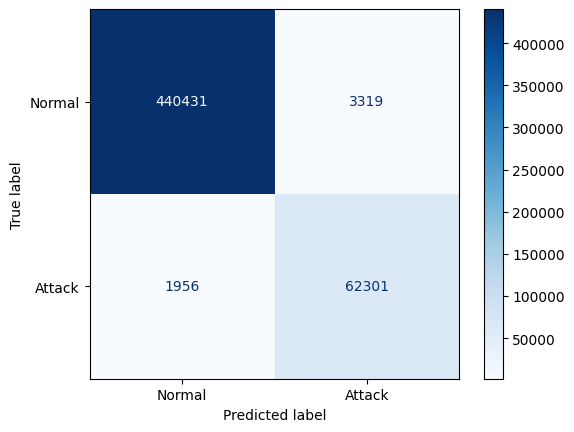

In [361]:
y_predicted = ada_boost_binary.predict(X_test[["dstip", "ct_state_ttl", "sttl", "srcip", "sbytes", "smeansz", "dmeansz", "Sload"]])
disp = ConfusionMatrixDisplay.from_predictions(y_test["Label"], y_predicted, display_labels = label, cmap = plt.cm.Blues)

plt.savefig("../data/files/results/visualizations/ada_boost_binary_confusion_matrix.png")

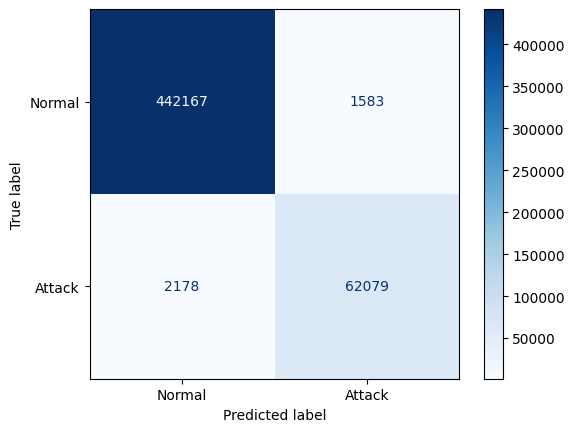

In [362]:
y_predicted =  random_forest_binary.predict(X_test[["dstip", "ct_state_ttl", "sttl", "srcip", "sbytes", "smeansz", "dmeansz", "Sload"]])
ConfusionMatrixDisplay.from_predictions(y_test["Label"], y_predicted, display_labels = label, cmap = plt.cm.Blues)

plt.savefig("../data/files/results/visualizations/random_forest_binary_confusion_matrix.png")

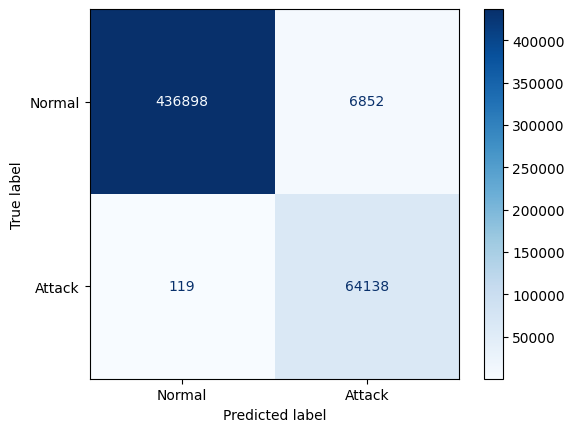

In [364]:
y_predicted =  bagging_binary.predict(X_test[["dstip", "ct_state_ttl", "sttl", "srcip", "sbytes", "smeansz", "dmeansz", "Sload"]])
ConfusionMatrixDisplay.from_predictions(y_test["Label"], y_predicted, display_labels = label, cmap = plt.cm.Blues)

plt.savefig("../data/files/results/visualizations/bagging_binary_confusion_matrix.png")

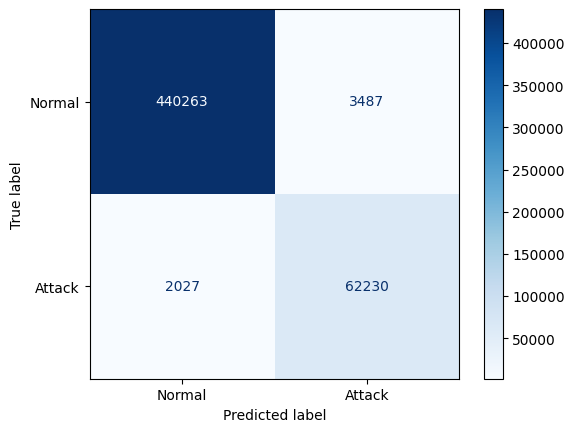

In [365]:
y_predicted =  mlp_binary.predict(X_test[["dstip", "ct_state_ttl", "sttl", "srcip", "sbytes", "smeansz", "dmeansz", "Sload"]])
ConfusionMatrixDisplay.from_predictions(y_test["Label"], y_predicted, display_labels = label, cmap = plt.cm.Blues)

plt.savefig("../data/files/results/visualizations/mlp_binary_confusion_matrix.png")

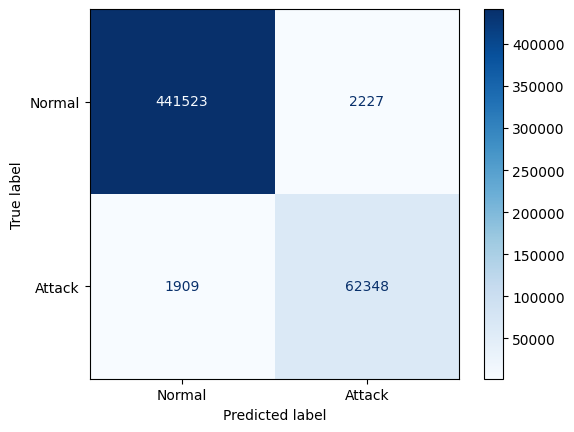

In [366]:
y_predicted =  xgboost_binary.predict(X_test[["dstip", "ct_state_ttl", "sttl", "srcip", "sbytes", "smeansz", "dmeansz", "Sload"]])
ConfusionMatrixDisplay.from_predictions(y_test["Label"], y_predicted, display_labels = label, cmap = plt.cm.Blues)

plt.savefig("../data/files/results/visualizations/xgboost_binary_confusion_matrix.png")

### Modelos multiclasse

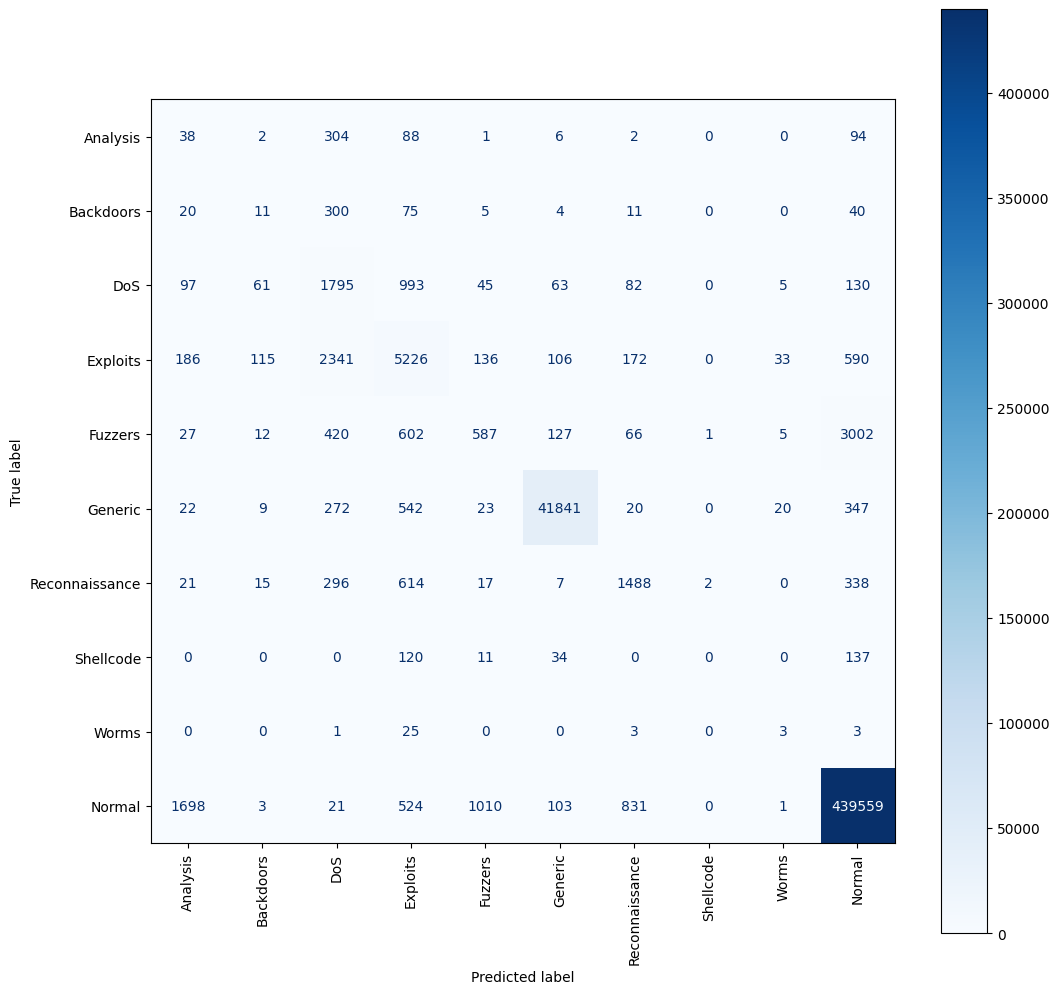

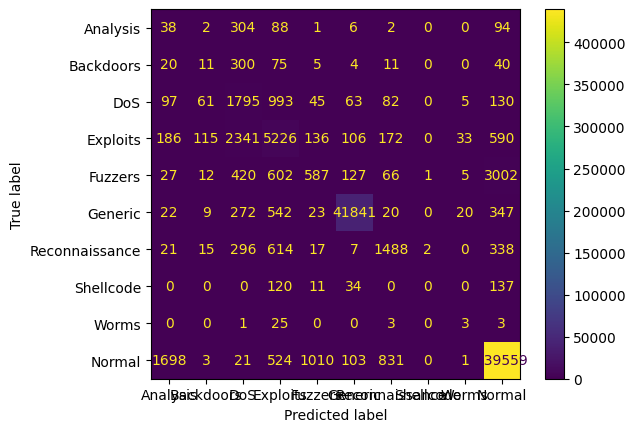

In [388]:
y_predicted =  ada_boost_multiclass.predict(X_test)

fig, ax = plt.subplots(figsize = (12, 12))
display = ConfusionMatrixDisplay.from_predictions(y_test["attack_cat"], y_predicted, display_labels = attack_cat).plot(xticks_rotation = 90, ax = ax, cmap = plt.cm.Blues)

display.figure_.savefig("../data/files/results/visualizations/ada_boost_multiclass_confusion_matrix.png")

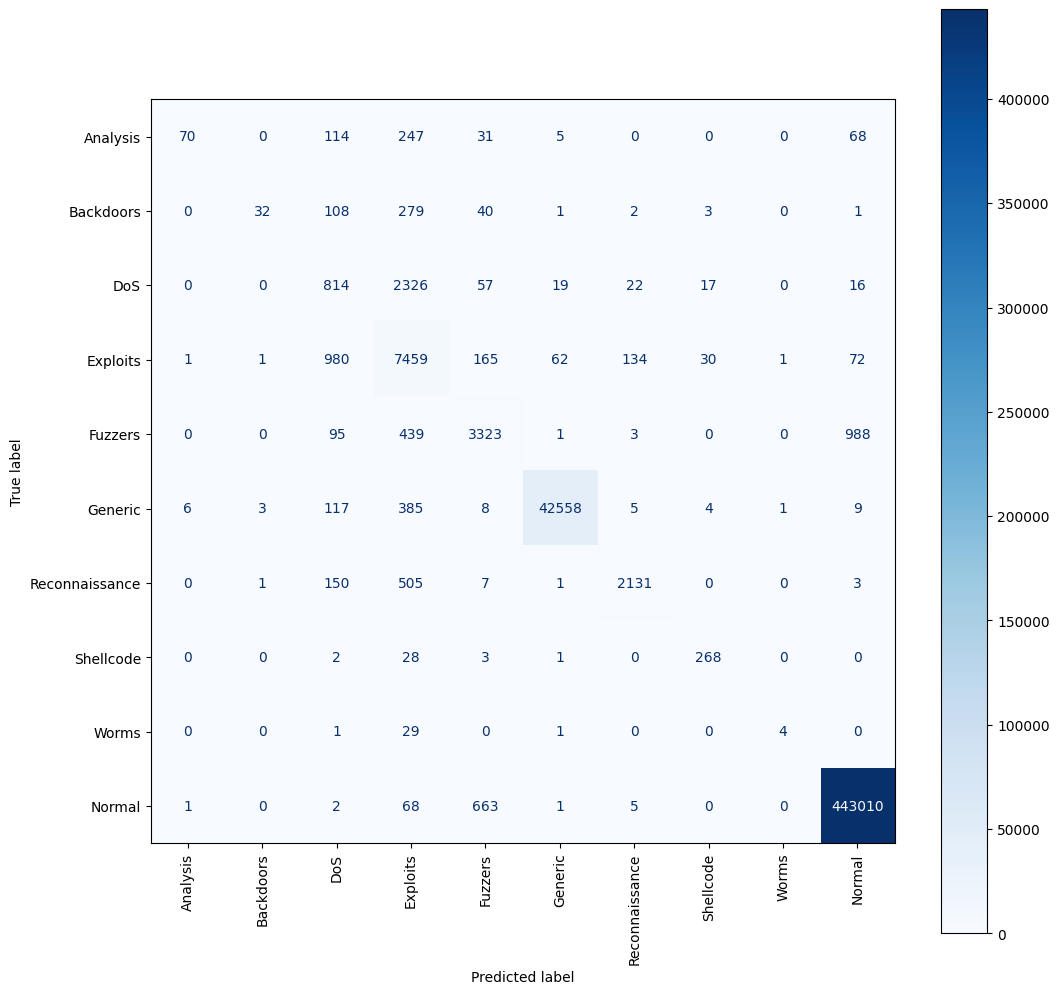

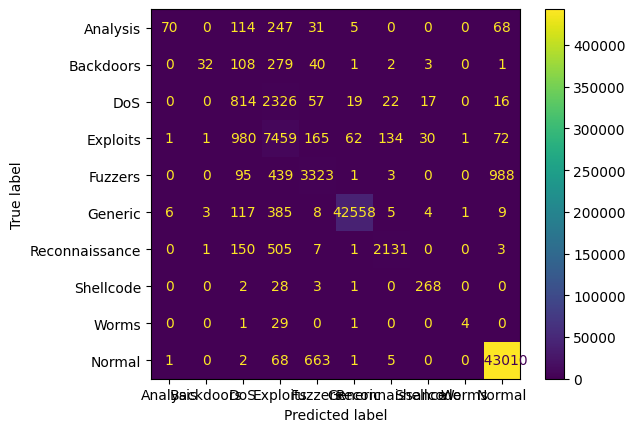

In [389]:
y_predicted =  random_forest_multiclass.predict(X_test)

fig, ax = plt.subplots(figsize = (12, 12))
display = ConfusionMatrixDisplay.from_predictions(y_test["attack_cat"], y_predicted, display_labels = attack_cat).plot(xticks_rotation = 90, ax = ax, cmap = plt.cm.Blues)

display.figure_.savefig("../data/files/results/visualizations/random_forest_multiclass_confusion_matrix.png")

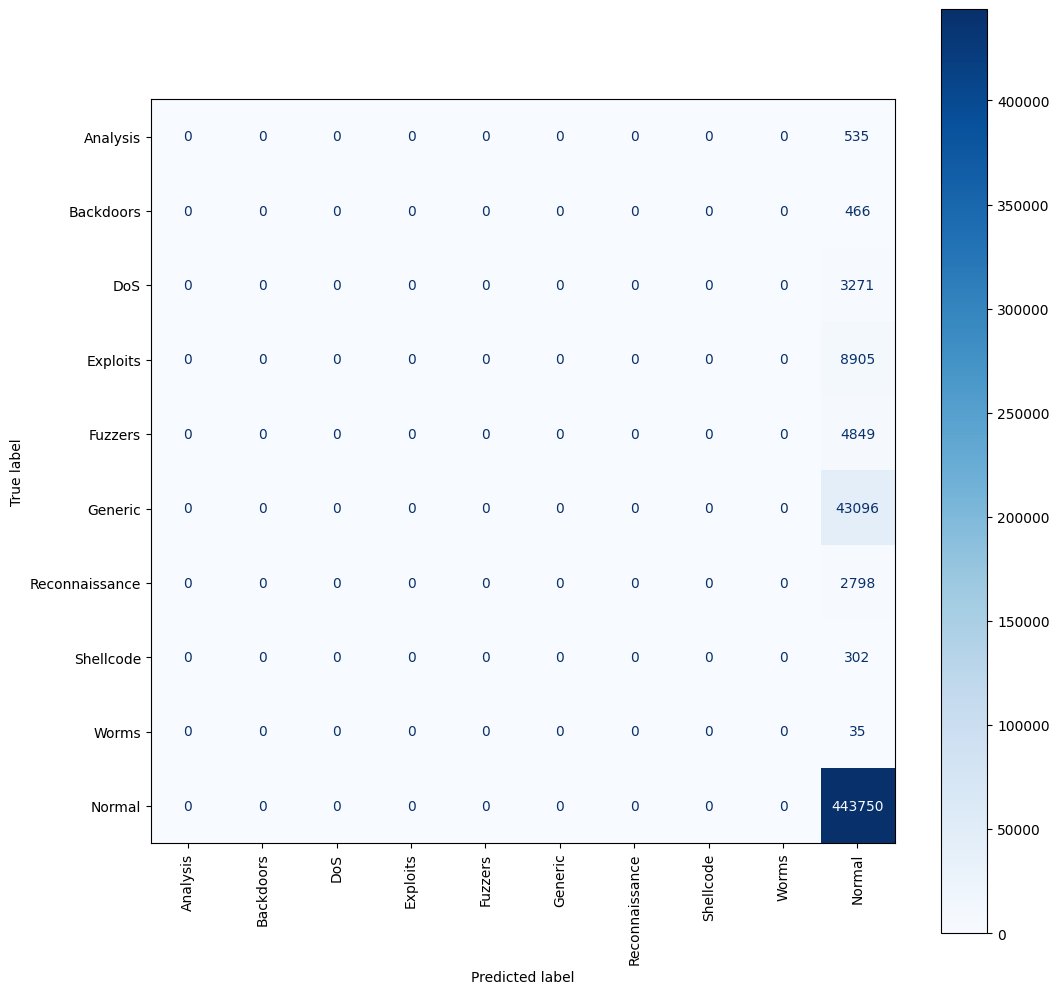

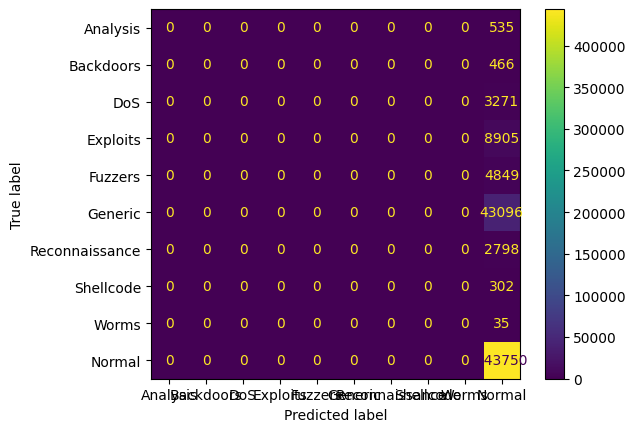

In [390]:
y_predicted =  bagging_multiclass.predict(X_test)

fig, ax = plt.subplots(figsize = (12, 12))
display = ConfusionMatrixDisplay.from_predictions(y_test["attack_cat"], y_predicted, display_labels = attack_cat).plot(xticks_rotation = 90, ax = ax, cmap = plt.cm.Blues)

display.figure_.savefig("../data/files/results/visualizations/bagging_multiclass_confusion_matrix.png")

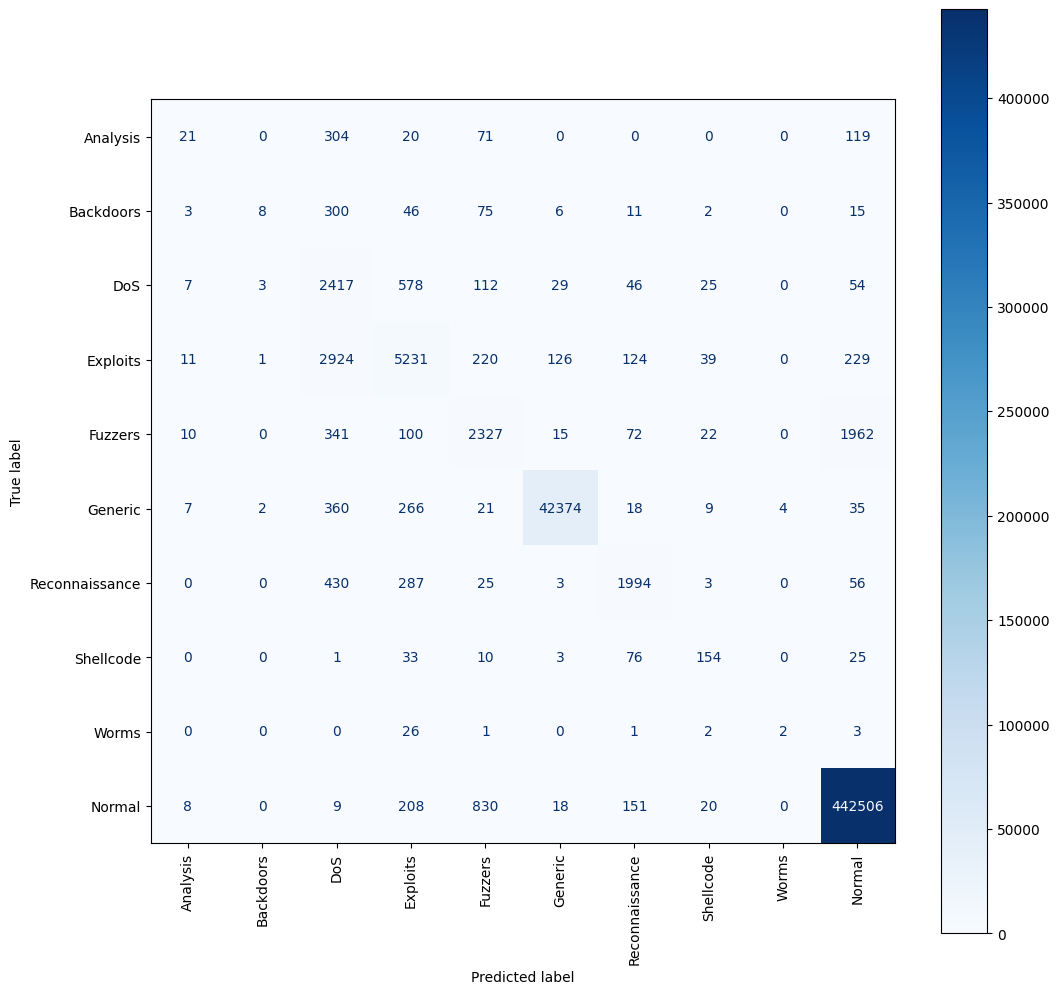

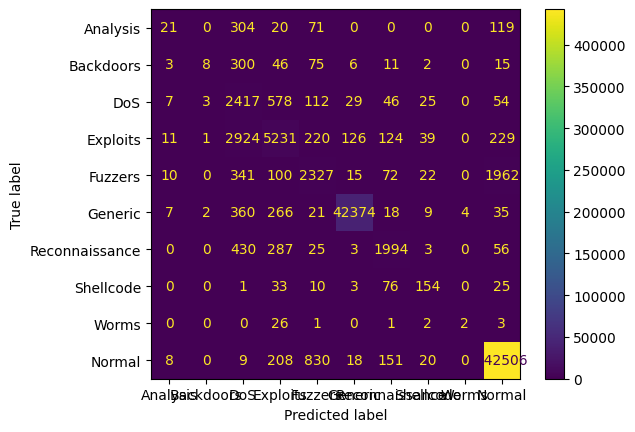

In [391]:
y_predicted =  mlp_multiclass.predict(X_test)

fig, ax = plt.subplots(figsize = (12, 12))
display = ConfusionMatrixDisplay.from_predictions(y_test["attack_cat"], y_predicted, display_labels = attack_cat).plot(xticks_rotation = 90, ax = ax, cmap = plt.cm.Blues)

display.figure_.savefig("../data/files/results/visualizations/mlp_multiclass_confusion_matrix.png")

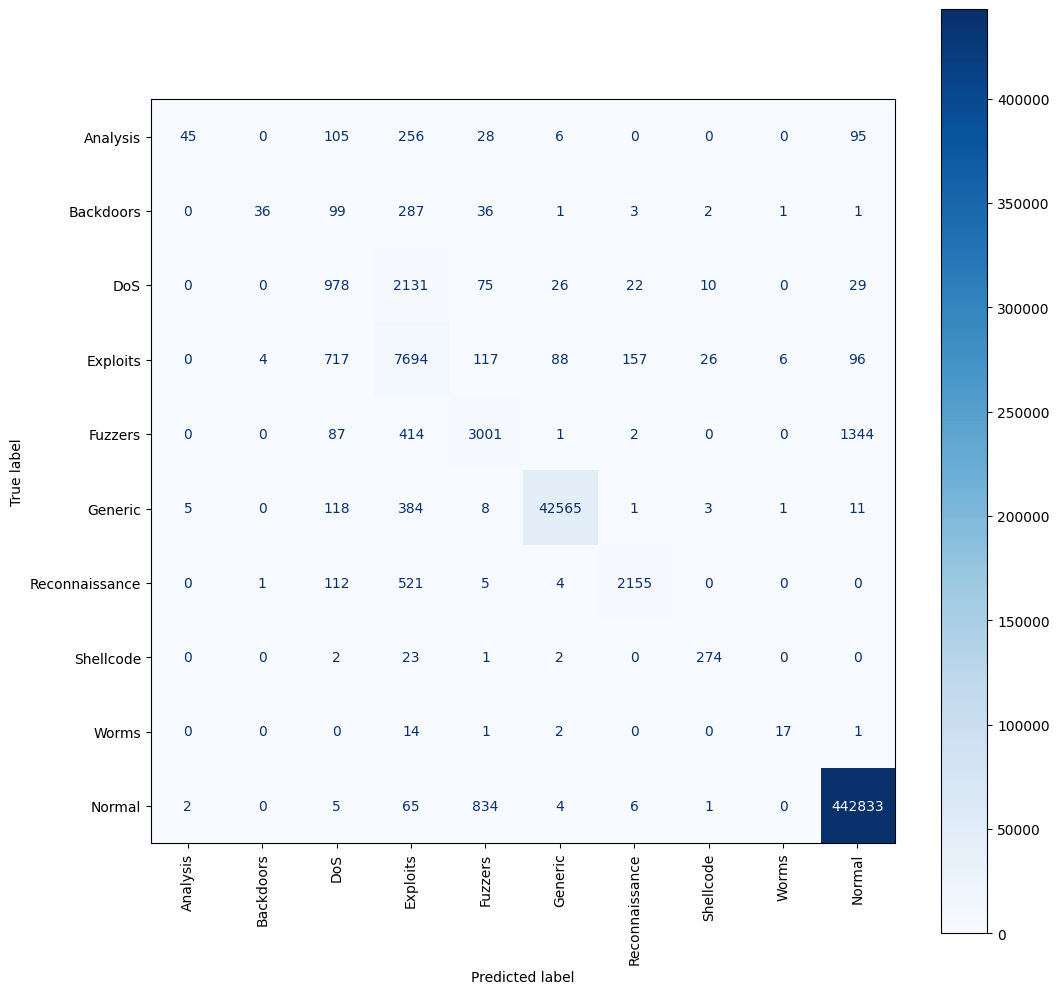

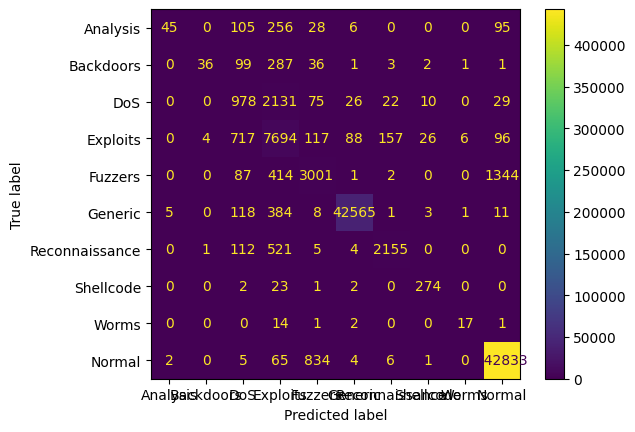

In [392]:
y_predicted =  xgboost_multiclass.predict(X_test)

fig, ax = plt.subplots(figsize = (12, 12))
display = ConfusionMatrixDisplay.from_predictions(y_test["attack_cat"], y_predicted, display_labels = attack_cat).plot(xticks_rotation = 90, ax = ax, cmap = plt.cm.Blues)

display.figure_.savefig("../data/files/results/visualizations/xgboost_multiclass_confusion_matrix.png")

## Modelos hierárquicos

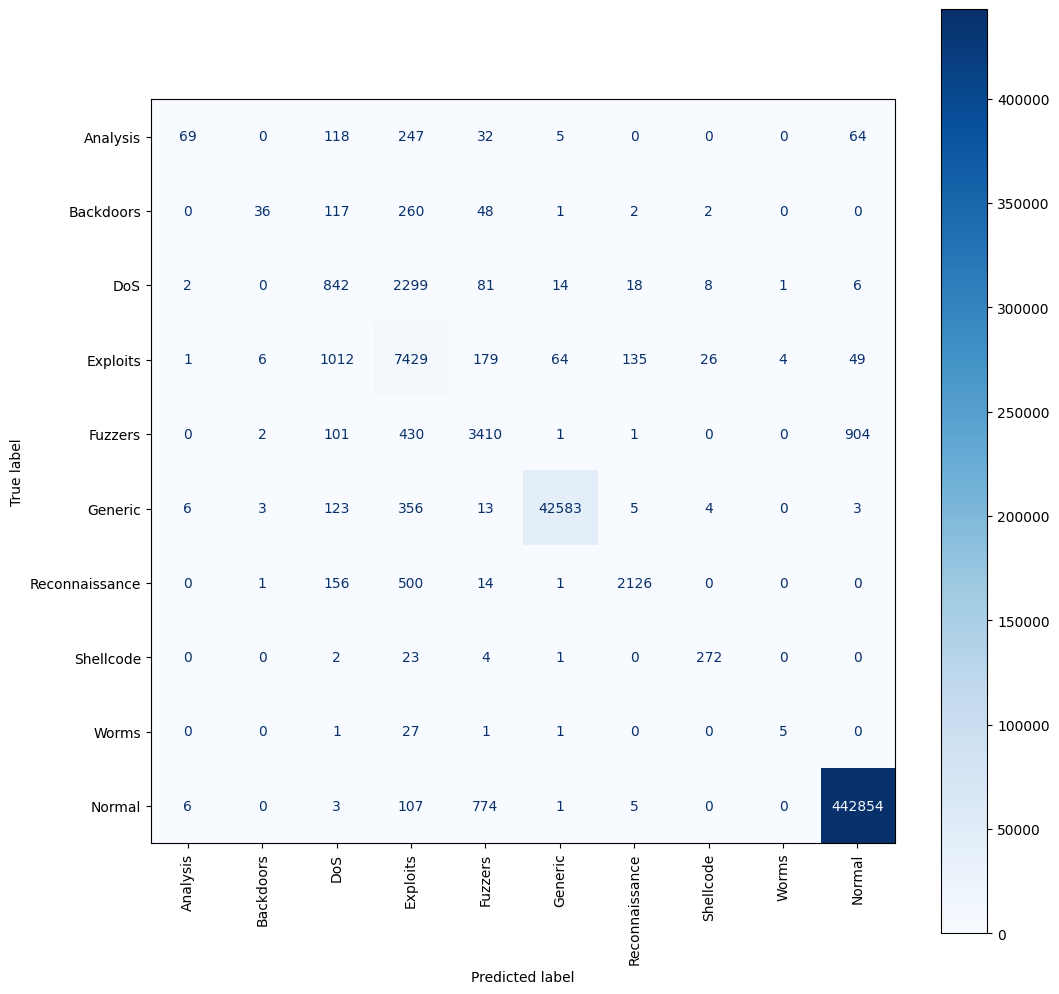

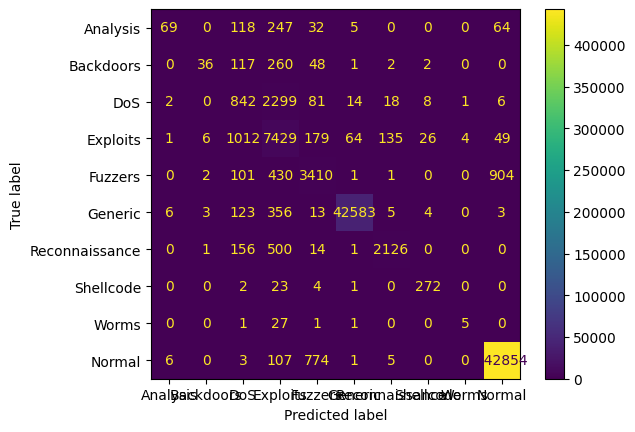

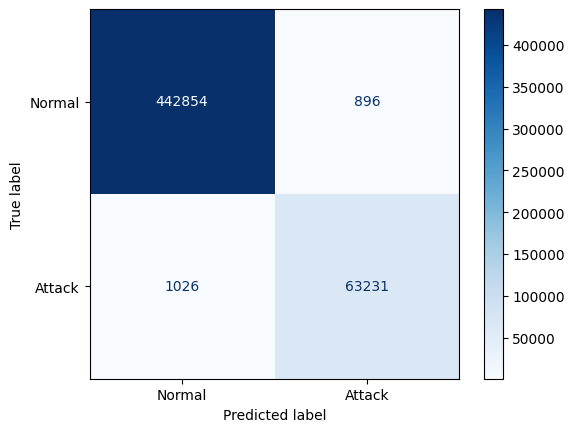

In [402]:
y_predicted =  local_classifier_per_node.predict(X_test)

fig, ax = plt.subplots(figsize = (12, 12))
display = ConfusionMatrixDisplay.from_predictions(y_test["attack_cat"], y_predicted[:, 1].astype(int), display_labels = attack_cat).plot(xticks_rotation = 90, ax = ax, cmap = plt.cm.Blues)

display.figure_.savefig("../data/files/results/visualizations/local_classifier_per_node_multiclass_confusion_matrix.png")


display = ConfusionMatrixDisplay.from_predictions(y_test["Label"], y_predicted[:, 0].astype(int), display_labels = label, cmap = plt.cm.Blues)

display.figure_.savefig("../data/files/results/visualizations/local_classifier_per_node_binary_confusion_matrix.png")

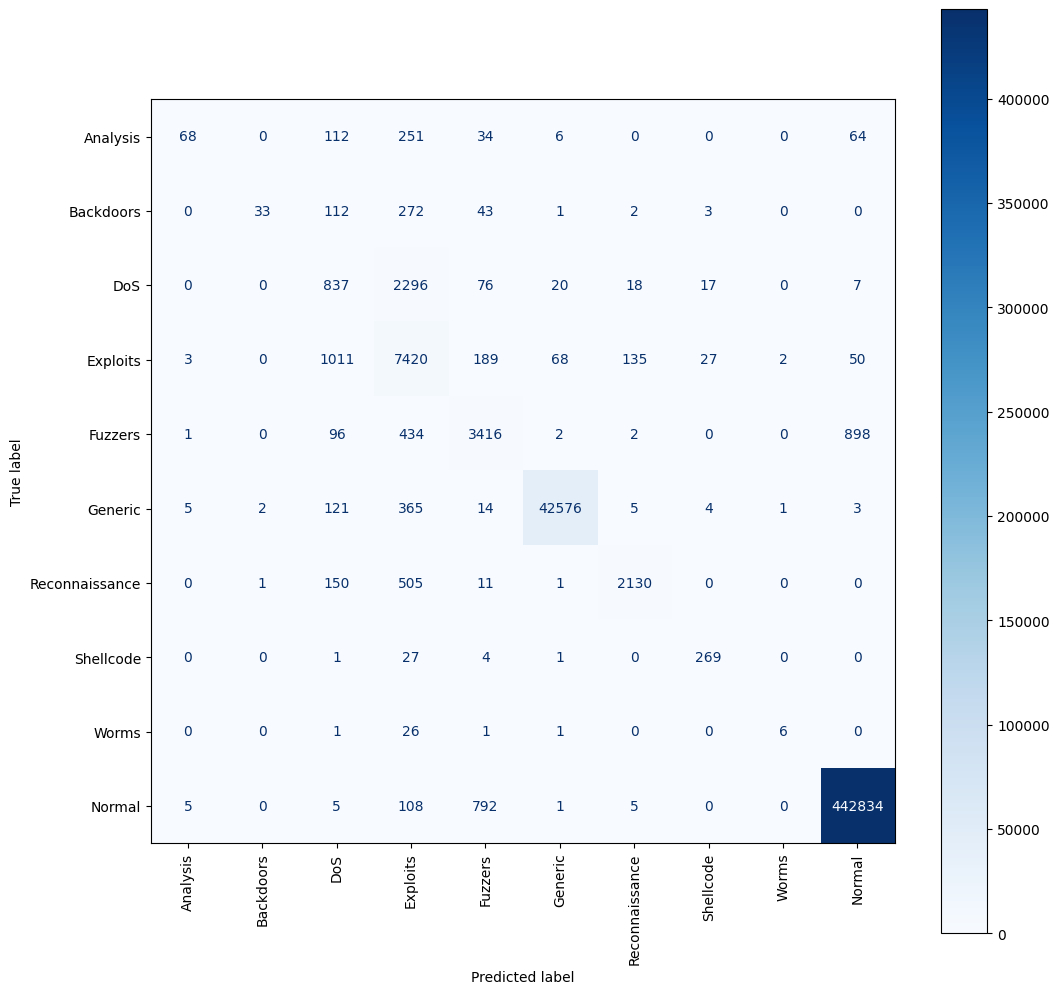

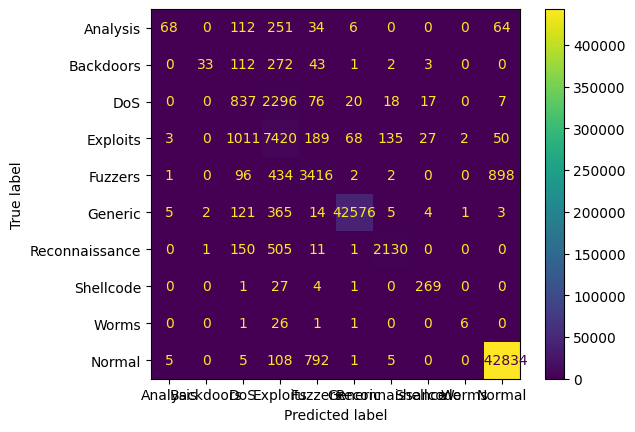

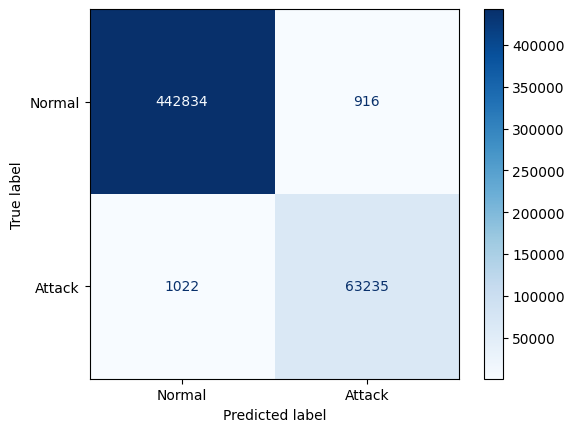

In [403]:
y_predicted =  local_classifier_per_parent_node.predict(X_test)

fig, ax = plt.subplots(figsize = (12, 12))
display = ConfusionMatrixDisplay.from_predictions(y_test["attack_cat"], y_predicted[:, 1].astype(int), display_labels = attack_cat).plot(xticks_rotation = 90, ax = ax, cmap = plt.cm.Blues)

display.figure_.savefig("../data/files/results/visualizations/local_classifier_per_parent_node_multiclass_confusion_matrix.png")


display = ConfusionMatrixDisplay.from_predictions(y_test["Label"], y_predicted[:, 0].astype(int), display_labels = label, cmap = plt.cm.Blues)

display.figure_.savefig("../data/files/results/visualizations/local_classifier_per_parent_node_binary_confusion_matrix.png")

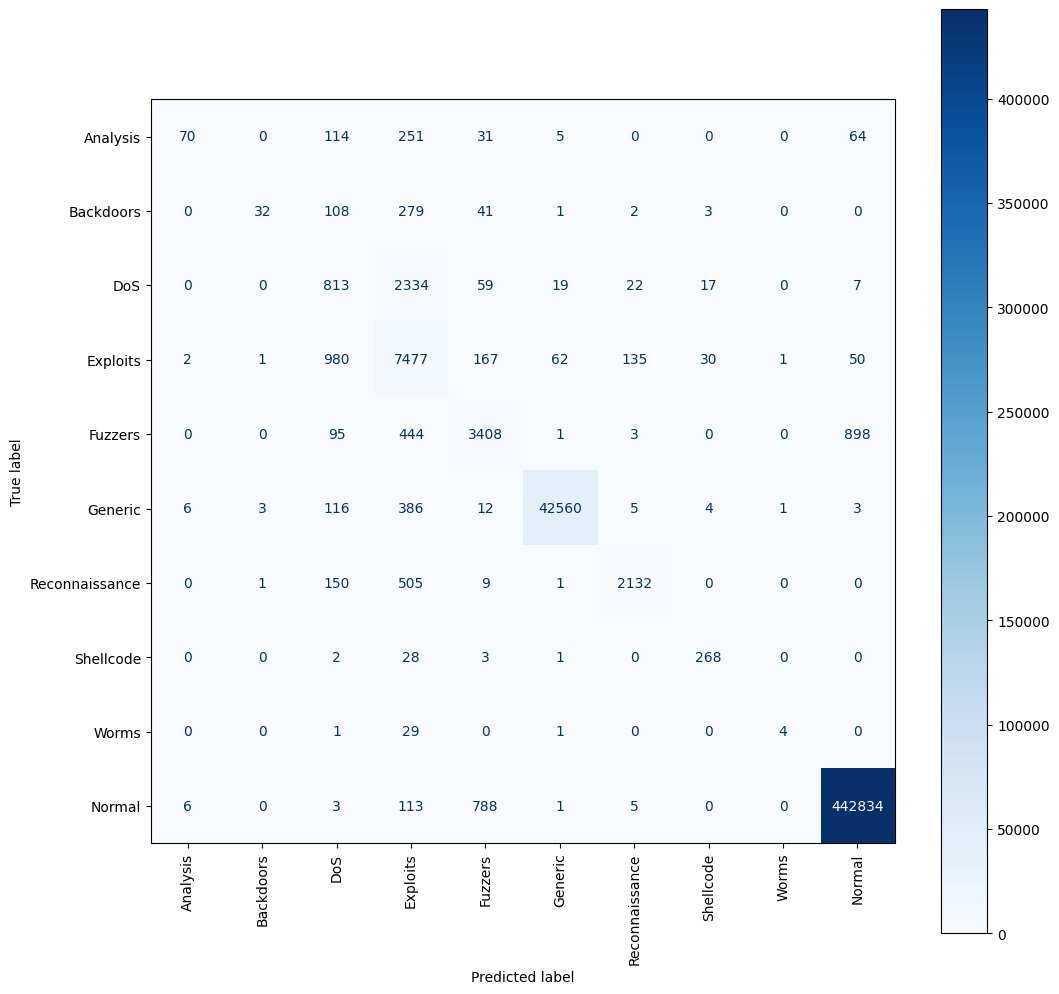

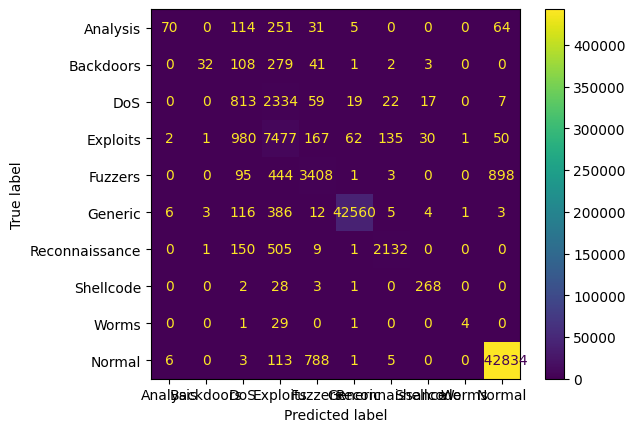

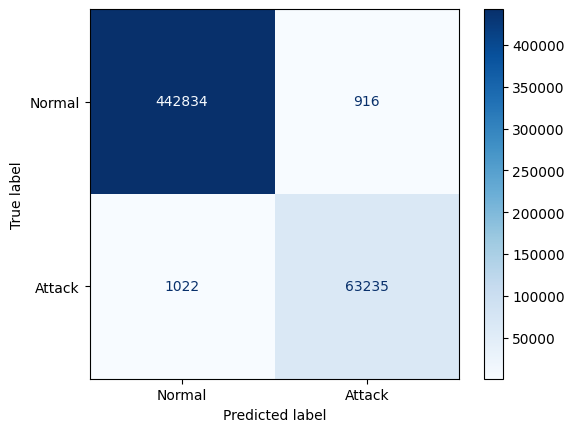

In [404]:
y_predicted =  local_classifier_per_level.predict(X_test)

fig, ax = plt.subplots(figsize = (12, 12))
display = ConfusionMatrixDisplay.from_predictions(y_test["attack_cat"], y_predicted[:, 1].astype(int), display_labels = attack_cat).plot(xticks_rotation = 90, ax = ax, cmap = plt.cm.Blues)

display.figure_.savefig("../data/files/results/visualizations/local_classifier_per_level_multiclass_confusion_matrix.png")


display = ConfusionMatrixDisplay.from_predictions(y_test["Label"], y_predicted[:, 0].astype(int), display_labels = label, cmap = plt.cm.Blues)

display.figure_.savefig("../data/files/results/visualizations/local_classifier_per_level_binary_confusion_matrix.png")